<h1>Regression with ANNs</h1>

# 1. Tensorflow (minimal)

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', test_split=0.2, seed=113
)

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=1,
    validation_data=(x_test, y_test)
)

Epoch 1/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 371.5382 - mae: 13.8755 - val_loss: 99.5939 - val_mae: 7.1678
Epoch 2/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 136.3121 - mae: 8.6603 - val_loss: 59.3063 - val_mae: 5.5413
Epoch 3/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 110.2907 - mae: 8.0510 - val_loss: 472.7584 - val_mae: 20.4257
Epoch 4/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 85.5088 - mae: 7.1155 - val_loss: 55.7074 - val_mae: 5.2318
Epoch 5/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 75.3975 - mae: 6.5396 - val_loss: 52.6116 - val_mae: 5.1320
Epoch 6/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 85.2199 - mae: 6.9386 - val_loss: 83.9145 - val_mae: 8.1073
Epoch 7/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 84.1815 - mae: 6.7646 - val_loss: 68.2867 - val_mae: 7.3013
Epoch 8/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 61.7896 - mae: 5.7540 - val_loss: 73.9145 - val_mae: 7.5494
Epoch 9/50
404/404 ━━━━━━━━━━━━━━━

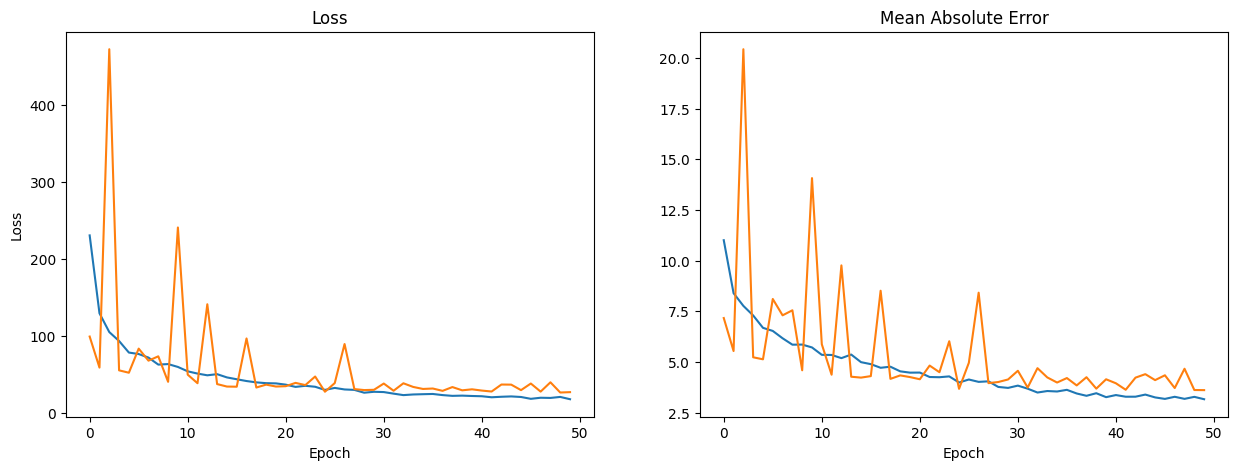

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(history.history['mae'])
ax[1].plot(history.history['val_mae'])
ax[1].set_title('Mean Absolute Error')
ax[1].set_xlabel('Epoch')

plt.show()

# 2. PyTorch

In [6]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from tqdm.notebook import tqdm

In [7]:
INPUT_DIMS = x_train.shape[1]
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

lr = 0.001
epochs = 100

In [ ]:
class RegressionNet(nn.Module):

    def __init__(self, input_dims: int = 13):
        super().__init__()
        self.fc1 = nn.Linear(input_dims, 64)
        self.bnorm1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bnorm2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 1)

        self.dropout = nn.Dropout(0.2)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bnorm1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bnorm2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc3(x)

        return x

In [8]:
train_data = TensorDataset(
    torch.from_numpy(x_train).float(),
    torch.unsqueeze(torch.from_numpy(y_train).float(), 1)
)

test_data = TensorDataset(
    torch.from_numpy(x_test).float(),
    torch.unsqueeze(torch.from_numpy(y_test).float(), 1)
)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = RegressionNet(input_dims = INPUT_DIMS)
model.to(DEVICE)

crit = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
history = {
    "train": [],
    "val": []
}

for epoch in range(epochs):
  model.train()
  epoch_train_loss = 0.0
  for X, y in tqdm(train_loader):
    X, y = X.to(DEVICE), y.to(DEVICE)
    opt.zero_grad()
    pred = model(X)
    loss = crit(pred, y)
    loss.backward()
    opt.step()

    epoch_train_loss += loss.item() / len(X)
  history["train"].append(epoch_train_loss)

  model.eval()
  epoch_val_loss = 0.0
  for X, y in test_loader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    with torch.no_grad():
      pred = model(X)
      loss = crit(pred, y)

      epoch_val_loss += loss.item() / len(X)
  history["val"].append(epoch_val_loss)

  log_epoch = f"Epoch ({epoch + 1:3d}/{epochs})   "
  log_epoch += f"Train Loss: {epoch_train_loss:.5}   "
  log_epoch += f"Val Loss: {epoch_val_loss:.5}"
  print(log_epoch)

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch (  1/100)   Train Loss: 235.02   Val Loss: 223.21


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch (  2/100)   Train Loss: 234.33   Val Loss: 220.74


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch (  3/100)   Train Loss: 230.68   Val Loss: 214.42


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch (  4/100)   Train Loss: 223.91   Val Loss: 209.2


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch (  5/100)   Train Loss: 214.42   Val Loss: 205.43


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch (  6/100)   Train Loss: 215.76   Val Loss: 202.03


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch (  7/100)   Train Loss: 204.67   Val Loss: 198.86


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch (  8/100)   Train Loss: 199.61   Val Loss: 193.77


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch (  9/100)   Train Loss: 188.23   Val Loss: 189.03


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 10/100)   Train Loss: 191.28   Val Loss: 184.65


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 11/100)   Train Loss: 181.74   Val Loss: 181.6


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 12/100)   Train Loss: 171.8   Val Loss: 171.71


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 13/100)   Train Loss: 167.85   Val Loss: 167.64


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 14/100)   Train Loss: 163.03   Val Loss: 162.77


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 15/100)   Train Loss: 150.77   Val Loss: 146.46


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 16/100)   Train Loss: 148.61   Val Loss: 146.69


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 17/100)   Train Loss: 138.61   Val Loss: 129.3


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 18/100)   Train Loss: 129.79   Val Loss: 115.33


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 19/100)   Train Loss: 122.35   Val Loss: 97.883


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 20/100)   Train Loss: 121.27   Val Loss: 91.514


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 21/100)   Train Loss: 111.08   Val Loss: 93.16


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 22/100)   Train Loss: 106.07   Val Loss: 94.992


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 23/100)   Train Loss: 96.446   Val Loss: 84.796


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 24/100)   Train Loss: 87.565   Val Loss: 64.651


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 25/100)   Train Loss: 84.643   Val Loss: 57.093


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 26/100)   Train Loss: 73.947   Val Loss: 43.56


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 27/100)   Train Loss: 70.816   Val Loss: 38.559


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 28/100)   Train Loss: 66.914   Val Loss: 56.217


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 29/100)   Train Loss: 60.102   Val Loss: 61.739


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 30/100)   Train Loss: 60.277   Val Loss: 43.584


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 31/100)   Train Loss: 53.713   Val Loss: 37.294


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 32/100)   Train Loss: 46.687   Val Loss: 23.419


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 33/100)   Train Loss: 45.97   Val Loss: 29.953


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 34/100)   Train Loss: 40.299   Val Loss: 24.617


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 35/100)   Train Loss: 37.287   Val Loss: 24.929


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 36/100)   Train Loss: 33.962   Val Loss: 22.338


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 37/100)   Train Loss: 31.471   Val Loss: 21.734


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 38/100)   Train Loss: 29.641   Val Loss: 23.25


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 39/100)   Train Loss: 26.806   Val Loss: 20.741


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 40/100)   Train Loss: 22.926   Val Loss: 20.943


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 41/100)   Train Loss: 23.554   Val Loss: 16.084


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 42/100)   Train Loss: 21.37   Val Loss: 15.424


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 43/100)   Train Loss: 20.609   Val Loss: 11.702


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 44/100)   Train Loss: 17.773   Val Loss: 14.781


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 45/100)   Train Loss: 19.365   Val Loss: 13.73


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 46/100)   Train Loss: 15.097   Val Loss: 13.634


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 47/100)   Train Loss: 15.759   Val Loss: 13.502


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 48/100)   Train Loss: 14.169   Val Loss: 14.003


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 49/100)   Train Loss: 13.535   Val Loss: 16.846


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 50/100)   Train Loss: 14.206   Val Loss: 13.423


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 51/100)   Train Loss: 14.193   Val Loss: 13.366


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 52/100)   Train Loss: 11.419   Val Loss: 17.087


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 53/100)   Train Loss: 15.794   Val Loss: 12.555


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 54/100)   Train Loss: 13.871   Val Loss: 15.14


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 55/100)   Train Loss: 11.788   Val Loss: 12.997


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 56/100)   Train Loss: 13.298   Val Loss: 12.693


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 57/100)   Train Loss: 11.919   Val Loss: 11.573


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 58/100)   Train Loss: 11.541   Val Loss: 11.955


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 59/100)   Train Loss: 14.684   Val Loss: 14.311


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 60/100)   Train Loss: 14.612   Val Loss: 15.034


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 61/100)   Train Loss: 13.452   Val Loss: 10.029


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 62/100)   Train Loss: 13.454   Val Loss: 14.36


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 63/100)   Train Loss: 10.626   Val Loss: 15.222


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 64/100)   Train Loss: 14.333   Val Loss: 16.177


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 65/100)   Train Loss: 12.771   Val Loss: 13.988


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 66/100)   Train Loss: 10.908   Val Loss: 9.7191


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 67/100)   Train Loss: 10.696   Val Loss: 16.483


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 68/100)   Train Loss: 11.671   Val Loss: 11.891


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 69/100)   Train Loss: 11.077   Val Loss: 13.919


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 70/100)   Train Loss: 10.35   Val Loss: 13.624


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 71/100)   Train Loss: 11.344   Val Loss: 14.409


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 72/100)   Train Loss: 11.774   Val Loss: 16.271


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 73/100)   Train Loss: 12.935   Val Loss: 24.122


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 74/100)   Train Loss: 11.093   Val Loss: 18.983


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 75/100)   Train Loss: 11.724   Val Loss: 12.126


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 76/100)   Train Loss: 10.82   Val Loss: 20.225


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 77/100)   Train Loss: 13.262   Val Loss: 17.812


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 78/100)   Train Loss: 11.926   Val Loss: 19.426


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 79/100)   Train Loss: 10.851   Val Loss: 15.162


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 80/100)   Train Loss: 12.41   Val Loss: 18.484


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 81/100)   Train Loss: 10.192   Val Loss: 20.393


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 82/100)   Train Loss: 11.714   Val Loss: 14.838


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 83/100)   Train Loss: 11.25   Val Loss: 18.06


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 84/100)   Train Loss: 11.969   Val Loss: 16.813


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 85/100)   Train Loss: 11.293   Val Loss: 16.91


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 86/100)   Train Loss: 11.946   Val Loss: 15.699


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 87/100)   Train Loss: 10.832   Val Loss: 15.374


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 88/100)   Train Loss: 9.9691   Val Loss: 18.69


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 89/100)   Train Loss: 9.5923   Val Loss: 17.209


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 90/100)   Train Loss: 10.986   Val Loss: 19.02


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 91/100)   Train Loss: 9.8528   Val Loss: 15.519


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 92/100)   Train Loss: 11.886   Val Loss: 17.96


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 93/100)   Train Loss: 9.1886   Val Loss: 20.961


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 94/100)   Train Loss: 10.091   Val Loss: 19.087


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 95/100)   Train Loss: 13.35   Val Loss: 15.433


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 96/100)   Train Loss: 10.132   Val Loss: 19.43


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 97/100)   Train Loss: 10.758   Val Loss: 15.14


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 98/100)   Train Loss: 9.6655   Val Loss: 17.101


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch ( 99/100)   Train Loss: 9.9741   Val Loss: 15.243


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch (100/100)   Train Loss: 8.8722   Val Loss: 22.42


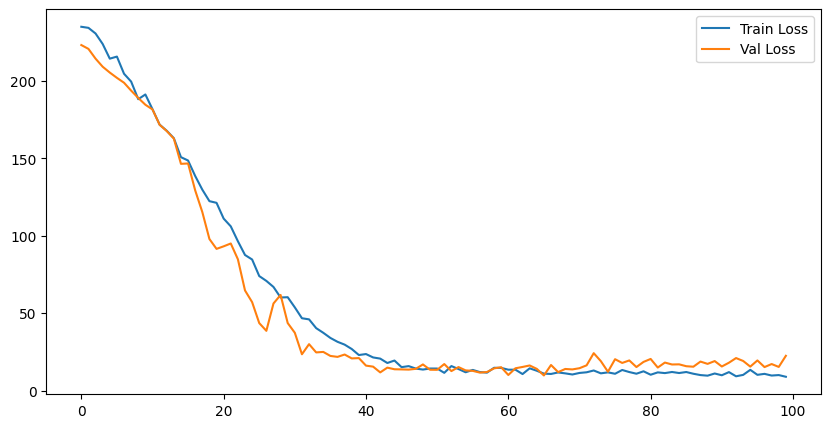

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history["train"], label="Train Loss")
plt.plot(history["val"], label="Val Loss")
plt.legend()
plt.show()

# JAX

In [22]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
from flax.training import train_state

from tqdm.auto import tqdm
from typing import Any
rng = jax.random.PRNGKey(69)

In [24]:
class RegressionANN(nn.Module):
  features: list[int]
  dropout_rate: float = 0.2

  @nn.compact
  def __call__(self, x, trainable: bool):
    for i, feature in enumerate(self.features[:-1]):
      x = nn.Dense(feature)(x)
      x = nn.BatchNorm(use_running_average=not trainable)(x)
      x = nn.tanh(x)
      x = nn.Dropout(rate=self.dropout_rate, deterministic=not trainable)(x)

    x = nn.Dense(self.features[-1])(x)
    return x

In [20]:
model = RegressionANN(
    [64, 32, 1],
    dropout_rate=0.2
)
print(model, "\n", "="*50, end="\n\n")

rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (1, 13))
variables  = model.init(init_rng, inp, trainable=False)
params = variables['params']
batch_stats = variables['batch_stats']
jax.tree_map(lambda x: x.shape, params)

RegressionANN(
    # attributes
    features = [64, 32, 1]
    dropout_rate = 0.2
) 



{'BatchNorm_0': {'bias': (64,), 'scale': (64,)},
 'BatchNorm_1': {'bias': (32,), 'scale': (32,)},
 'Dense_0': {'bias': (64,), 'kernel': (13, 64)},
 'Dense_1': {'bias': (32,), 'kernel': (64, 32)},
 'Dense_2': {'bias': (1,), 'kernel': (32, 1)}}

In [25]:
class TrainState(train_state.TrainState):
  key: jax.Array
  batch_stats: Any

rng, dropout_key = jax.random.split(rng, 2)

model_state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    batch_stats=batch_stats,
    key=dropout_key,
    tx=optax.adam(learning_rate=lr)
    )

In [26]:
def loss_fn(state, params, batch, trainable: bool, rng=None):
  data_input, labels = batch
  logits = state.apply_fn(
      {"params": params, 'batch_stats': state.batch_stats},
      x = data_input,
      trainable=trainable,
      mutable=['batch_stats'],
      rngs={'dropout': rng}).squeeze(axis=-1)
  loss = optax.l2_loss(logits, labels)
  mae = jnp.mean(jnp.abs(logits - labels))
  return loss, mae

@jax.jit
def train_step(state, batch, rng):
    rng, dropout_rng = jax.random.split(rng)
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, mae), grads = grad_fn(state, state.params, batch, True, rng)
    state = state.apply_gradients(grads=grads)
    return state, loss, mae

@jax.jit
def eval_step(state, batch):
    loss, mae = loss_fn(state, state.params, batch, False)
    return loss, mae

In [27]:
def jax_collate_fn(batch):
    batch_x, batch_y = zip(*batch)
    return jnp.array(batch_x), jnp.array(batch_y)

#we'll keep using our pytorch dataloaders
train_loader_jx = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=jax_collate_fn)
test_loader_jx = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=jax_collate_fn)

In [28]:
def train_model(state, train_loader, val_loader, rng, num_epochs=100):
    rng, dropout_rng = jax.random.split(rng)
    history = {
        "train": [],
        "val": []
    }

    for epoch in range(num_epochs):
        train_epoch_loss = 0.0
        for batch in tqdm(train_loader):
            state, loss, acc = train_step(state, batch, rng)
            train_epoch_loss += jnp.mean(loss) / len(batch)
        history["train"].append(train_epoch_loss)

        val_epoch_loss = 0.0
        for batch in val_loader:
            loss, acc = eval_step(state, batch)
            val_epoch_loss += jnp.mean(loss) / len(batch)
        history["val"].append(val_epoch_loss)

    return state, history

In [30]:
state, hist = train_model(model_state, train_loader_jx, test_loader_jx, rng, epochs)